In [1]:
import os
import json
import torch
import numpy as np
from losses import MaskedMSELoss
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from matplotlib.ticker import MultipleLocator 
from models import TransformerEncoderInputter
from datasets import ImputationDataset, find_padding_masks

**Autoregressive denoising**  
Warm up model weights by filling in masked values

In [2]:
# Create model

# dropout = 0.1 dropout
# n_heads = 8 number of heads
# num_layers = 1 number of layers
# feat_dim = 35 number of features
# max_len = 40 max length of sequence
# d_model = 64 dimension of the model
# freeze = False freeze the model True --> no dropout
# dim_feedforward = 256 dimension of the feedforward layers within the transformer blocks
model = TransformerEncoderInputter(feat_dim=35,
                                    max_len=40,
                                    d_model=64, 
                                    n_heads=8, 
                                    num_layers=1,
                                    dim_feedforward=256, 
                                    dropout=0.1, 
                                    freeze=False)

# Create an instance of the model and set to float (default is double)
model.float();

In [3]:
# Read in train and validation indices

with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
train_indices = data_indices['train_indices']
val_indices = data_indices['val_indices']

In [4]:
# Create loaders

train_dataloader = DataLoader(ImputationDataset(train_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=10, shuffle=True, drop_last=True)
val_dataloader = DataLoader(ImputationDataset(val_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=10, shuffle=True, drop_last=True)
x, mask, label = next(iter(train_dataloader))
x.shape, mask.shape, label.shape # (batch, seq_length, feat_dim)

(torch.Size([10, 40, 35]), torch.Size([10, 40, 35]), torch.Size([10]))

In [5]:
# Define the traning loop

def train_and_validate(model, train_loader, test_loader, n_epoch):

    best_test_loss = 1e20
    running_batch_loss_train = []
    running_batch_loss_test = []
    save_path = '../models/inputting_unity_norm.pt'
    if 'inputting_unity_norm.pt' in os.listdir(os.path.dirname(save_path)):os.remove(save_path)

    model.train()
    for epoch in range(n_epoch):
        print(epoch + 1)
        for x, mask, _ in train_loader:
            x_masked = x * mask # mask the input
            padding_mask = find_padding_masks(x) # shape (batchsize, max_seq_len) to pad start of short sequences
            padding_mask_expand = padding_mask.unsqueeze(dim=2) # use torch.repeat to expand the added dimension to match the size of the mask tensor
            padding_mask_expand = padding_mask_expand.repeat(1, 1, 35) # use torch.repeat to expand the added dimension to match the size of the mask tensor
            target_masks = padding_mask_expand & ~mask # which points to compare for loss inverse since 1 if compare, 0 if ignore, & means only True if both are True: sets zeros for padding and zeros for non-masked

            x = x.to(device)
            x_masked = x_masked.to(device)
            target_masks = target_masks.to(device)
            padding_mask = padding_mask.to(device)

            y_hat = model(x_masked, padding_mask)
            loss = critereon(y_hat, x, target_masks)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
            optimizer.step()
            running_batch_loss_train.append(loss.item())

            model.eval()
            with torch.no_grad():
                x, mask, _ = next(iter(test_loader))
                x_masked = x * mask # mask the input
                padding_mask = find_padding_masks(x) # shape (batchsize, max_seq_len) to pad start of short sequences
                padding_mask_expand = padding_mask.unsqueeze(dim=2) # use torch.repeat to expand the added dimension to match the size of the mask tensor
                padding_mask_expand = padding_mask_expand.repeat(1, 1, 35) # use torch.repeat to expand the added dimension to match the size of the mask tensor
                target_masks = padding_mask_expand & ~mask # which points to compare for loss inverse since 1 if compare, 0 if ignore, & means only True if both are True: sets zeros for padding 

                x = x.to(device)
                x_masked = x_masked.to(device)
                target_masks = target_masks.to(device)
                padding_mask = padding_mask.to(device)
      
                y_hat = model(x_masked, padding_mask)
                loss = critereon(y_hat, x, target_masks)
                running_batch_loss_test.append(loss.item())

            if loss < best_test_loss:
                best_test_loss = loss
                torch.save(model.state_dict(), save_path)

        print(f"Epoch Train Loss: {np.nanmean(running_batch_loss_train)}\nEpoch Test Loss: {np.nanmean(running_batch_loss_test)}")
                
    return running_batch_loss_train, running_batch_loss_test

torch.Size([40, 10, 64])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, na

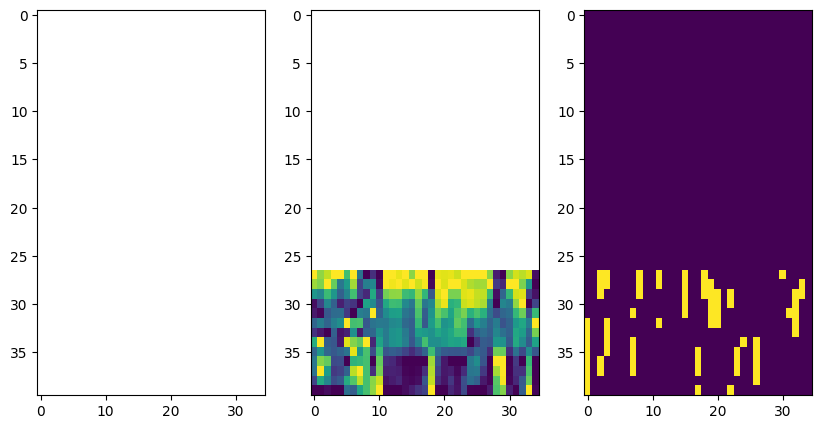

In [9]:
for x, mask, _ in train_dataloader:
    x_masked = x * mask # mask the input
    padding_mask = find_padding_masks(x) # shape (batchsize, max_seq_len) to pad start of short sequences
    padding_mask_expand = padding_mask.unsqueeze(dim=2) # use torch.repeat to expand the added dimension to match the size of the mask tensor
    padding_mask_expand = padding_mask_expand.repeat(1, 1, 35) # use torch.repeat to expand the added dimension to match the size of the mask tensor
    target_masks = padding_mask_expand & ~mask # which points to compare for loss inverse since 1 if compare, 0 if ignore, & means only True if both are True: sets zeros for padding and zeros f

    x = x.to(device)
    x_masked = x_masked.to(device)
    target_masks = target_masks.to(device)
    padding_mask = padding_mask.to(device)

    y_hat = model(x_masked, padding_mask)
    loss = critereon(y_hat, x, target_masks)

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(y_hat[0].detach().numpy(), aspect='auto')
    ax[1].imshow(x[0].detach().numpy(), aspect='auto')
    ax[2].imshow(target_masks[0].detach().numpy(), aspect='auto')

    # print(y_hat)
    # print(x_masked.shape)
    # plt.show()

    print(loss.item())

    break 

In [7]:
# Set device, initiate optimizer, define loss criterion, and set number of epoch

n_epoch = 100
critereon = MaskedMSELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
# running_batch_loss_train, running_batch_loss_test = train_and_validate(model, train_dataloader, val_dataloader, n_epoch)

In [3]:
# Read in train and validation indices

with open('../data/data_indices.json', 'r') as f:
    data_indices = json.load(f)

train_indices = data_indices['train_indices']
val_indices = data_indices['val_indices']

In [21]:
# Create train and validation loaders for the inputting task

train_dataloader = DataLoader(ImputationDataset(train_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=10, shuffle=True, drop_last=True)
val_dataloader = DataLoader(ImputationDataset(val_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=10, shuffle=True, drop_last=True)
x, mask, label = next(iter(train_dataloader))
x.shape, mask.shape, label.shape # (batch, seq_length, feat_dim)

(torch.Size([10, 40, 35]), torch.Size([10, 40, 35]), torch.Size([10]))

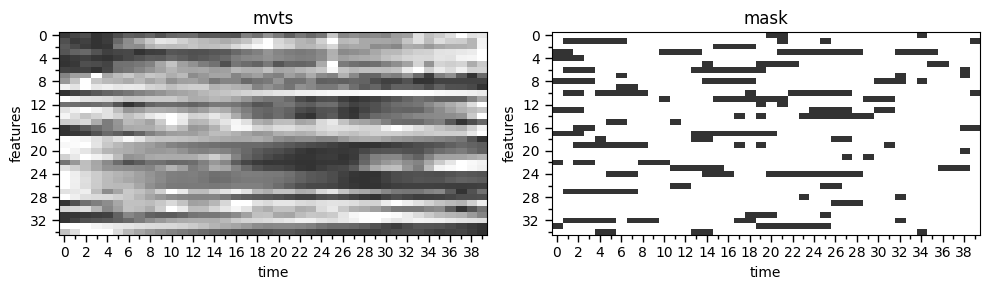

In [22]:
# Plot mvts and mask

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.set_title('mvts')
ax1.set_ylabel('features')
ax1.set_xlabel('time')
ax1.imshow(x[0, :, :].numpy().T, aspect='auto', alpha=0.8, cmap='gray')
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(4))
ax1.yaxis.set_minor_locator(MultipleLocator(2))
ax1.tick_params(which='major', length=5,width=1)
ax1.tick_params(which='minor', length=3,width=1)
ax2.set_title('mask')
ax2.set_ylabel('features')
ax2.set_xlabel('time')
ax2.imshow(mask[0, :, :].numpy().T, aspect='auto', alpha=0.8, cmap='gray')
ax2.xaxis.set_major_locator(MultipleLocator(2))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(4))
ax2.yaxis.set_minor_locator(MultipleLocator(2))
ax2.tick_params(which='major', length=5,width=1)
ax2.tick_params(which='minor', length=3,width=1)
plt.tight_layout()
plt.show()
plt.close()

In [82]:
padding_masks = find_padding_masks(x) 
padding_masks.shape

torch.Size([1, 40])

In [83]:
padding_masks

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])